### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [67]:
import numpy as np
import pandas as pd

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [68]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [69]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

### Your code is here
print(data['passenger_count'].isna().value_counts())
print(data['distance_km'].isna().value_counts())

passenger_count
False    1312780
True      145864
Name: count, dtype: int64
distance_km
False    1312780
True      145864
Name: count, dtype: int64


Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [70]:
### Your code is here
print(data['passenger_count'].value_counts())
data['passenger_count'].fillna(930.399753, inplace=True)
data['passenger_count'].isna().value_counts()

passenger_count
930.399753     930354
1005.458335    189262
1070.232174     70348
1028.236276     53751
1061.355223     43460
1053.529749     25543
1718.433333        57
19.666667           3
560.000000          1
104.000000          1
Name: count, dtype: int64


C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_11816\2706649537.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['passenger_count'].fillna(930.399753, inplace=True)


passenger_count
False    1458644
Name: count, dtype: int64

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [71]:
### Your code is here
grouped_means = data.groupby(['vendor_id', 'store_and_fwd_flag', 'traffic_jam', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6'])['distance_km'].transform("mean")
data['distance_km'] = data['distance_km'].fillna(grouped_means)

In [72]:
### Убедимся, что пропусков не осталось

### Your code is here
print(data['distance_km'].isna().value_counts())
data.head(20).to_csv('task7.csv', sep=';', index=False)

distance_km
False    1458644
Name: count, dtype: int64


### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [73]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here
X = data.drop('log_trip_duration', axis=1)
y = data['log_trip_duration']

losses_test = []
losses_train = []

for train_index, test_index in selector.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, Y_train)

    losses_test.append(np.mean((model.predict(X_test)-Y_test)**2))
    losses_train.append(np.mean((model.predict(X_train)-Y_train)**2))

cross_val_error = np.mean(losses_test)

print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: 0.431


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

{'whiskers': [<matplotlib.lines.Line2D at 0x1a596a85580>,
 'caps': [<matplotlib.lines.Line2D at 0x1a596a85ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a596a85280>],
 'medians': [<matplotlib.lines.Line2D at 0x1a596a85f40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a596a861e0>],
 'means': []}

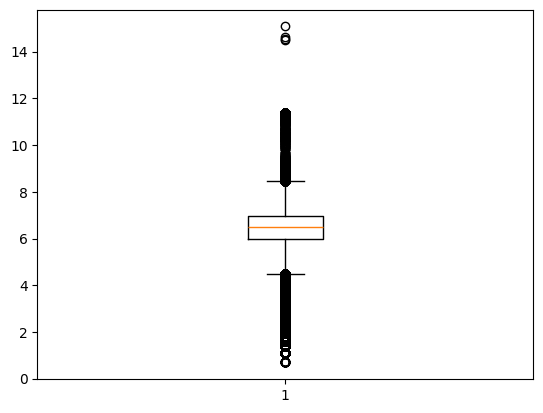

In [74]:
import matplotlib.pyplot as plt

### Your code is here
plt.boxplot(data['log_trip_duration'])


(array([1.53900e+03, 3.85400e+03, 4.02660e+04, 6.43870e+05, 7.33102e+05,
        3.39050e+04, 1.23000e+02, 1.98100e+03, 0.00000e+00, 4.00000e+00]),
 array([ 0.69314718,  2.13140795,  3.56966872,  5.0079295 ,  6.44619027,
         7.88445104,  9.32271181, 10.76097258, 12.19923336, 13.63749413,
        15.0757549 ]),
 <BarContainer object of 10 artists>)

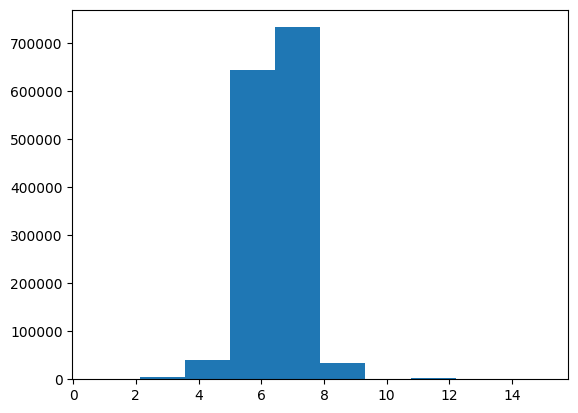

In [75]:
plt.hist(data['log_trip_duration'])

Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [79]:
### Your code is here
top_p = data['log_trip_duration'].quantile(0.995)
bottom_p = data['log_trip_duration'].quantile(0.005)
r = top_p - bottom_p

data_new = data[(data['log_trip_duration'] > bottom_p) & (data['log_trip_duration'] < top_p)]

Снова замерьте качество на кросс-валидации, используя старый selector

In [81]:
### Your code is here
X = data_new.drop('log_trip_duration', axis=1)
y = data_new['log_trip_duration']

selector = KFold(n_splits=4, shuffle=True, random_state=33)

losses_test = []
losses_train = []

for train_index, test_index in selector.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, Y_train)

    losses_test.append(np.mean((model.predict(X_test)-Y_test)**2))
    losses_train.append(np.mean((model.predict(X_train)-Y_train)**2))

cross_val_error = np.mean(losses_test)

print(f"MSLE на Кросс-валидации: {round(cross_val_error, 5)}")

MSLE на Кросс-валидации: 0.34959
